# Template

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



def styled(obj, caption="", dots=False):
    # If the object is a Series, convert it to a DataFrame
    if isinstance(obj, pd.Series):
        obj = obj.to_frame().T  # Convert Series to one-row DataFrame

    # If the number of rows or columns is small, display the table as is
    if isinstance(obj, pd.DataFrame) and obj.shape[0] <= 3 and obj.shape[1] <= 3:
        return (
            obj.style
            .set_properties(**{'text-align': 'left'})
            .set_table_styles([
                {'selector': 'th', 'props': [('text-align', 'left')]},
                {'selector': '.row_heading', 'props': [('text-align', 'left')]}
            ])
            .set_caption(caption)
        )

    # Handle dots view for large DataFrames
    if dots and isinstance(obj, pd.DataFrame) and len(obj) > 6:
        head = obj.head(3)
        tail = obj.tail(3)

        # Create a DataFrame with the same columns and '...' as a row
        ellipsis_row = pd.DataFrame([['...'] * obj.shape[1]], columns=obj.columns)
        ellipsis_row.index = ['...']  # Set a placeholder index

        # Concatenate with original indexes preserved
        obj = pd.concat([head, ellipsis_row, tail])

    return (
        obj.style
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'left')]},
            {'selector': '.row_heading', 'props': [('text-align', 'left')]}
        ])
        .set_caption(caption)
    )



# EDA

In [2]:
import json
import pandas as pd

data = []
with open("python_data.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
styled(df.head())

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   src         4900 non-null   object
 1   complexity  4900 non-null   object
 2   problem     4900 non-null   object
 3   from        4900 non-null   object
 4   tags        4900 non-null   object
dtypes: object(5)
memory usage: 191.5+ KB


In [4]:
print("Total samples:", len(df))
print("Nulls count per column:")
print(df.isnull().sum())


Total samples: 4900
Nulls count per column:
src           0
complexity    0
problem       0
from          0
tags          0
dtype: int64


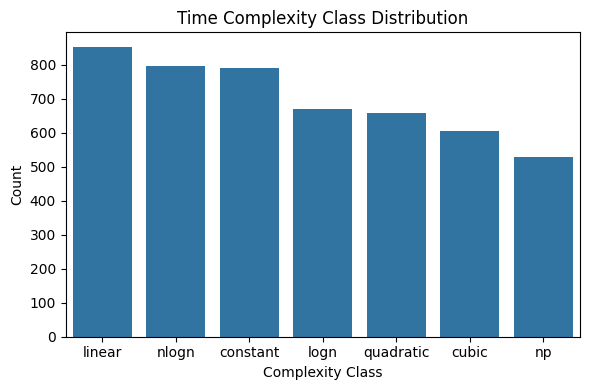

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(
    x="complexity",
    data=df,
    order=df["complexity"].value_counts().index
)
plt.title("Time Complexity Class Distribution")
plt.xlabel("Complexity Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


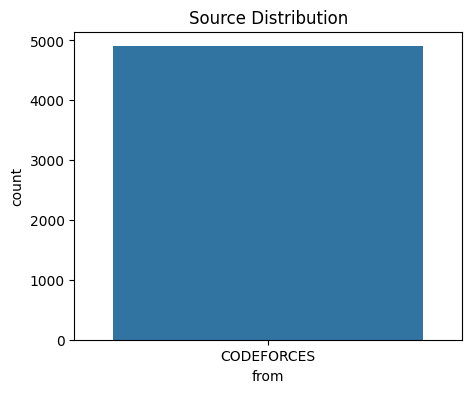

In [6]:
plt.figure(figsize=(5,4))
sns.countplot(
    x="from",
    data=df,
    order=df["from"].value_counts().index
)
plt.title("Source Distribution")
plt.show()


In [7]:
from collections import Counter

all_tags = []
for tags in df["tags"]:
    all_tags.extend(tags.split(","))

tag_counts = Counter(all_tags)

tag_df = pd.DataFrame(
    tag_counts.items(),
    columns=["tag", "count"]
).sort_values("count", ascending=False)

styled(tag_df.head(10))


,tag,count
0,implementation,1838
1,math,1753
5,dp,1413
6,greedy,1366
3,brute force,955
10,bitmasks,720
9,binary search,647
15,sortings,642
4,constructive algorithms,456
8,graphs,373


In [8]:
from collections import Counter

all_tags = []
for tags in df["tags"]:
    all_tags.extend(tags.split(","))

tag_counts = Counter(all_tags)

tag_df = pd.DataFrame(
    tag_counts.items(),
    columns=["tag", "count"]
).sort_values("count", ascending=False)

styled(tag_df.head(10))


,tag,count
0,implementation,1838
1,math,1753
5,dp,1413
6,greedy,1366
3,brute force,955
10,bitmasks,720
9,binary search,647
15,sortings,642
4,constructive algorithms,456
8,graphs,373


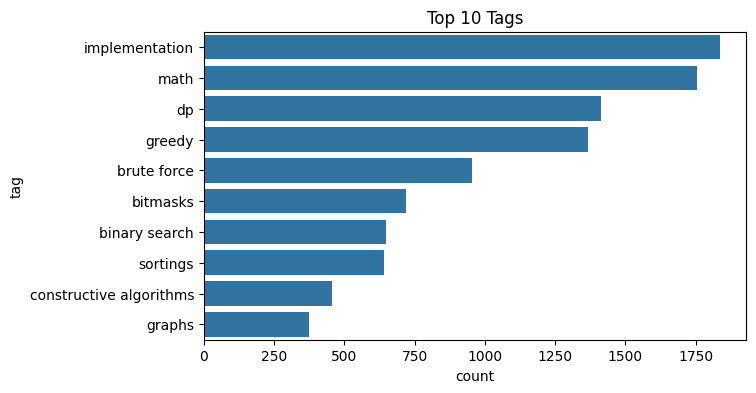

In [9]:
plt.figure(figsize=(7,4))
sns.barplot(
    data=tag_df.head(10),
    x="count",
    y="tag"
)
plt.title("Top 10 Tags")
plt.show()


In [10]:
df["code_length"] = df["src"].apply(len)
df["num_lines"] = df["src"].apply(lambda x: x.count("\n") + 1)
df["num_chars"] = df["src"].apply(len)


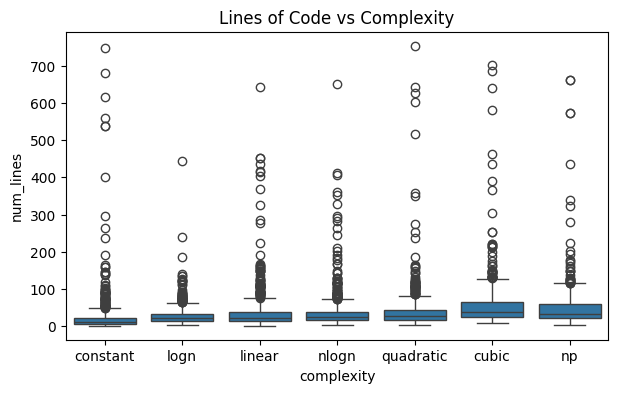

In [11]:
plt.figure(figsize=(7,4))
sns.boxplot(x="complexity", y="num_lines", data=df)
plt.title("Lines of Code vs Complexity")
plt.show()


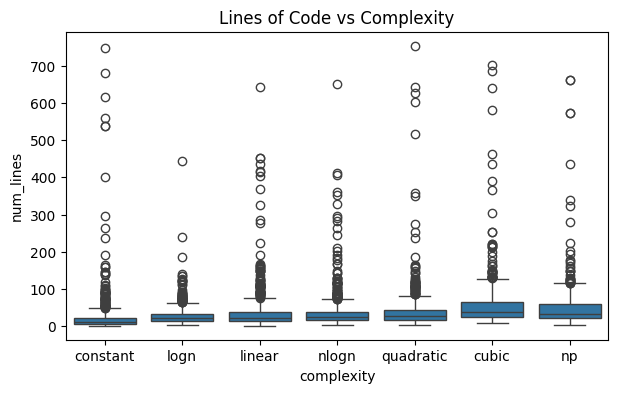

In [12]:
plt.figure(figsize=(7,4))
sns.boxplot(x="complexity", y="num_lines", data=df)
plt.title("Lines of Code vs Complexity")
plt.show()


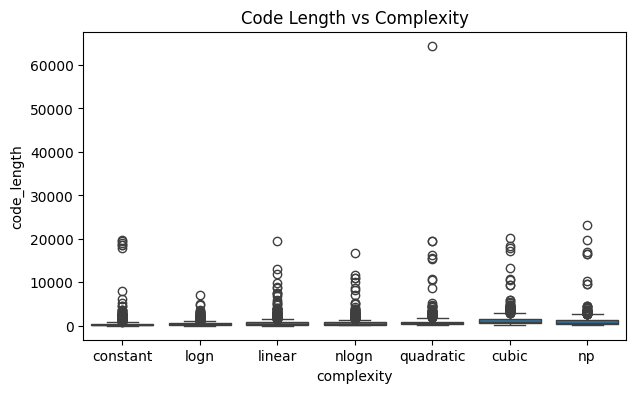

In [13]:
plt.figure(figsize=(7,4))
sns.boxplot(x="complexity", y="code_length", data=df)
plt.title("Code Length vs Complexity")
plt.show()


In [14]:
styled(df["problem"].value_counts().head(10))


problem,0992_C,1398_D,1517_D,1177_B,0276_D,1195_B,0550_B,0476_B,0915_C,1080_D
count,138,132,131,123,118,112,95,80,77,68


In [15]:
df["problem"].nunique()


277

In [16]:
complexity_per_problem = (
    df.groupby("problem")["complexity"]
      .nunique()
      .sort_values(ascending=False)
)

styled(complexity_per_problem.head(10))


problem,1080_D,1059_C,1037_D,1195_B,1062_D,1197_A,1075_B,1033_C,1056_D,1191_B
complexity,5,4,3,3,3,3,3,3,3,3


In [17]:
top_problems = (
    df.groupby("problem")["complexity"]
      .nunique()
      .sort_values(ascending=False)
      .head(10)
      .index
)

styled(df[df["problem"].isin(top_problems)] \
  .groupby("problem")["complexity"] \
  .unique())



problem,1033_C,1037_D,1056_D,1059_C,1062_D,1075_B,1080_D,1191_B,1195_B,1197_A
complexity,['linear' 'nlogn' 'quadratic'],['linear' 'nlogn' 'quadratic'],['linear' 'nlogn' 'quadratic'],['constant' 'logn' 'linear' 'nlogn'],['linear' 'nlogn' 'quadratic'],['linear' 'nlogn' 'quadratic'],['constant' 'logn' 'linear' 'nlogn' 'quadratic'],['constant' 'linear' 'nlogn'],['constant' 'logn' 'linear'],['constant' 'linear' 'nlogn']


# Data Cleaning

Removing comments

In [18]:
import ast

def remove_comments_and_docstrings(code: str) -> str:
    try:
        parsed = ast.parse(code)
    except SyntaxError:
        # If code is broken, return original
        return code

    class CodeCleaner(ast.NodeTransformer):
        def visit_FunctionDef(self, node):
            self.generic_visit(node)
            if (
                node.body
                and isinstance(node.body[0], ast.Expr)
                and isinstance(node.body[0].value, ast.Constant)
                and isinstance(node.body[0].value.value, str)
            ):
                node.body.pop(0)  # remove docstring
            return node

        def visit_ClassDef(self, node):
            self.generic_visit(node)
            if (
                node.body
                and isinstance(node.body[0], ast.Expr)
                and isinstance(node.body[0].value, ast.Constant)
                and isinstance(node.body[0].value.value, str)
            ):
                node.body.pop(0)
            return node

        def visit_Module(self, node):
            self.generic_visit(node)
            if (
                node.body
                and isinstance(node.body[0], ast.Expr)
                and isinstance(node.body[0].value, ast.Constant)
                and isinstance(node.body[0].value.value, str)
            ):
                node.body.pop(0)
            return node

    parsed = CodeCleaner().visit(parsed)
    ast.fix_missing_locations(parsed)

    return ast.unparse(parsed)


In [19]:
df["code"] = df["src"].apply(remove_comments_and_docstrings)

<unknown>:10: SyntaxWarning: invalid escape sequence '\/'
<unknown>:121: SyntaxWarning: invalid escape sequence '\ '
<unknown>:142: SyntaxWarning: invalid escape sequence '\ '
<unknown>:3: SyntaxWarning: invalid escape sequence '\_'
<unknown>:7: SyntaxWarning: invalid escape sequence '\d'
<unknown>:23: SyntaxWarning: invalid escape sequence '\D'
<unknown>:21: SyntaxWarning: invalid escape sequence '\d'
<unknown>:4: SyntaxWarning: invalid escape sequence '\/'
<unknown>:7: SyntaxWarning: invalid escape sequence '\c'


Keep only needed columns

In [20]:
df_clean = df[["code", "complexity"]].copy()


In [21]:
styled(df_clean.head())

,code,complexity
0,"from math import sqrt a, v = map(int, input().split()) l, d, w = map(int, input().split()) def findt(u, v, a, dist): front = (v * v - u * u) / (2 * a) if front > dist: return (sqrt(u * u + 2 * a * dist) - u) / a return (v - u) / a + (dist - front) / v def solve(a, v, l, d, w): if v <= w or 2 * a * d <= w * w: return findt(0, v, a, l) after = findt(w, v, a, l - d) peak = sqrt(a * d + w * w / 2) if peak > v: travel = (v * v - w * w / 2) / a before = (2 * v - w) / a + (d - travel) / v else: before = (2 * peak - w) / a return before + after print(f'{solve(a, v, l, d, w):.8f}')",constant
1,"from math import * a, vm = map(int, input().split()) l, d, vd = map(int, input().split()) if vm <= vd or sqrt(2 * a * d) <= vd: if vm ** 2 / (2 * a) >= l: ans = sqrt(2 * l / a) else: ans = vm / a + (l - vm ** 2 / (2 * a)) / vm else: s1 = (vm ** 2 - vd ** 2) / (2 * a) if s1 >= l - d: ans = (sqrt(4 * vd ** 2 + 8 * a * (l - d)) - 2 * vd) / (2 * a) else: ans = (vm - vd) / a + (l - d - s1) / vm v1 = sqrt((2 * a * d + vd ** 2) / 2) if v1 <= vm: ans = ans + v1 / a + (v1 - vd) / a else: s1 = d - (vm ** 2 - vd ** 2) / (2 * a) - vm ** 2 / (2 * a) ans = ans + vm / a + (vm - vd) / a + s1 / vm print('%.12f' % ans)",constant
2,"import os import sys from io import BytesIO, IOBase import heapq as h from bisect import bisect_left, bisect_right import time from types import GeneratorType BUFSIZE = 8192 class FastIO(IOBase): newlines = 0 def __init__(self, file): import os self.os = os self._fd = file.fileno() self.buffer = BytesIO() self.writable = 'x' in file.mode or 'r' not in file.mode self.write = self.buffer.write if self.writable else None def read(self): while True: b = self.os.read(self._fd, max(self.os.fstat(self._fd).st_size, BUFSIZE)) if not b: break ptr = self.buffer.tell() (self.buffer.seek(0, 2), self.buffer.write(b), self.buffer.seek(ptr)) self.newlines = 0 return self.buffer.read() def readline(self): while self.newlines == 0: b = self.os.read(self._fd, max(self.os.fstat(self._fd).st_size, BUFSIZE)) self.newlines = b.count(b'\n') + (not b) ptr = self.buffer.tell() (self.buffer.seek(0, 2), self.buffer.write(b), self.buffer.seek(ptr)) self.newlines -= 1 return self.buffer.readline() def flush(self): if self.writable: self.os.write(self._fd, self.buffer.getvalue()) (self.buffer.truncate(0), self.buffer.seek(0)) class IOWrapper(IOBase): def __init__(self, file): self.buffer = FastIO(file) self.flush = self.buffer.flush self.writable = self.buffer.writable self.write = lambda s: self.buffer.write(s.encode('ascii')) self.read = lambda: self.buffer.read().decode('ascii') self.readline = lambda: self.buffer.readline().decode('ascii') sys.stdin, sys.stdout = (IOWrapper(sys.stdin), IOWrapper(sys.stdout)) input = lambda: sys.stdin.readline().rstrip('\r\n') from collections import defaultdict as dd, deque as dq, Counter as dc import string from math import sqrt def getInts(): return [int(s) for s in input().split()] def getInt(): return int(input()) def getStrs(): return [s for s in input().split()] def getStr(): return input() def listStr(): return list(input()) def getMat(n): return [getInts() for _ in range(n)] def isInt(s): return '0' <= s[0] <= '9' MOD = 10 ** 9 + 7 '\nS = U T + 0.5 A T^2\nV^2 = U^2 + 2 A S\nV = U + A T\nS = V T - 0.5 A T^2\n\nIf V < W:\n linearly accelerate to V, then cruise to the end\n\nIf V >= W:\n If we can get to speed W in distance <= D:\n cruise to W, then reach the max speed such that we can still decelerate to W. Then post camera, accelerate to V and then cruise\n Else:\n linearly accelerate all the way to speed V, then cruise to the end\n\n2*W*T + A * T^2 - 2*rem_dist = 0\n' def t_from_s_a_u(s, a, u): return (-2 * u + sqrt(4 * u * u + 8 * s * a)) / (2 * a) def solve(): A, V = getInts() L, D, W = getInts() if V <= W or W ** 2 >= 2 * A * D: if V ** 2 >= 2 * A * L: return sqrt(2 * L / A) else: dist_1 = V ** 2 / (2 * A) T1 = 2 * dist_1 / V dist_2 = L - dist_1 T2 = dist_2 / V return T1 + T2 else: dist_1 = W ** 2

In [22]:
df_clean.to_json(
    "code_complexity.jsonl",
    orient="records",
    lines=True
)


# Feature Extraction From Data

In [23]:
import ast

class ComplexityFeatureExtractor(ast.NodeVisitor):
    def __init__(self):
        # ---------- Loop structure ----------
        self.num_loops = 0
        self.num_for = 0
        self.num_while = 0
        self.current_loop_depth = 0
        self.max_loop_depth = 0
        self.has_nested_loops = 0

        # ---------- Growth behavior ----------
        self.loop_bound_type = "unknown"  # constant | linear | log | mixed | unknown
        self.has_log_update = 0
        self.uses_sort = 0

        # ---------- Recursion ----------
        self.function_name = None
        self.recursion_flag = 0
        self.num_recursive_calls = 0

        # ---------- Control flow ----------
        self.has_break = 0
        self.has_continue = 0
        self.has_early_return = 0
        self.num_return = 0

        # ---------- Hidden loops ----------
        self.uses_comprehension = 0
        self.uses_generator = 0

        # ---------- Calls ----------
        self.num_function_calls = 0

        # ---------- Data structures ----------
        self.uses_list = 0
        self.uses_dict = 0
        self.uses_set = 0
        self.uses_tuple = 0

    # ---------- Utilities ----------
    def _enter_loop(self):
        self.current_loop_depth += 1
        self.max_loop_depth = max(self.max_loop_depth, self.current_loop_depth)
        if self.current_loop_depth > 1:
            self.has_nested_loops = 1

    def _exit_loop(self):
        self.current_loop_depth -= 1

    def _set_loop_bound(self, kind):
        if self.loop_bound_type == "unknown":
            self.loop_bound_type = kind
        elif self.loop_bound_type != kind:
            self.loop_bound_type = "mixed"

    # ---------- Functions ----------
    def visit_FunctionDef(self, node):
        self.function_name = node.name
        self.generic_visit(node)
        self.function_name = None

    # ---------- Loops ----------
    def visit_For(self, node):
        self.num_loops += 1
        self.num_for += 1
        self._enter_loop()

        # range(...) → linear
        if isinstance(node.iter, ast.Call) and isinstance(node.iter.func, ast.Name):
            if node.iter.func.id == "range":
                self._set_loop_bound("linear")

        self.generic_visit(node)
        self._exit_loop()

    def visit_While(self, node):
        self.num_loops += 1
        self.num_while += 1
        self._enter_loop()
        self.generic_visit(node)
        self._exit_loop()

    # ---------- Calls / recursion / sort ----------
    def visit_Call(self, node):
        self.num_function_calls += 1

        # recursion
        if isinstance(node.func, ast.Name):
            if node.func.id == self.function_name:
                self.recursion_flag = 1
                self.num_recursive_calls += 1

            if node.func.id == "sorted":
                self.uses_sort = 1
                self._set_loop_bound("linear")

        # list.sort()
        if isinstance(node.func, ast.Attribute):
            if node.func.attr == "sort":
                self.uses_sort = 1
                self._set_loop_bound("linear")

        self.generic_visit(node)

    # ---------- Logarithmic update ----------
    def visit_AugAssign(self, node):
        if isinstance(node.op, (ast.FloorDiv, ast.RShift)):
            self.has_log_update = 1
            self._set_loop_bound("log")
        self.generic_visit(node)

    # ---------- Control flow ----------
    def visit_Break(self, node):
        self.has_break = 1

    def visit_Continue(self, node):
        self.has_continue = 1

    def visit_Return(self, node):
        self.num_return += 1
        if self.current_loop_depth > 0:
            self.has_early_return = 1
        self.generic_visit(node)

    # ---------- Hidden loops ----------
    def visit_ListComp(self, node):
        self.uses_comprehension = 1
        self._set_loop_bound("linear")
        self.generic_visit(node)

    def visit_SetComp(self, node):
        self.uses_comprehension = 1
        self._set_loop_bound("linear")
        self.generic_visit(node)

    def visit_DictComp(self, node):
        self.uses_comprehension = 1
        self._set_loop_bound("linear")
        self.generic_visit(node)

    def visit_GeneratorExp(self, node):
        self.uses_generator = 1
        self._set_loop_bound("linear")
        self.generic_visit(node)

    # ---------- Data structures ----------
    def visit_List(self, node):
        self.uses_list = 1
        self.generic_visit(node)

    def visit_Dict(self, node):
        self.uses_dict = 1
        self.generic_visit(node)

    def visit_Set(self, node):
        self.uses_set = 1
        self.generic_visit(node)

    def visit_Tuple(self, node):
        self.uses_tuple = 1
        self.generic_visit(node)

In [24]:
def extract_complexity_features(code: str) -> dict:
    tree = ast.parse(code)
    extractor = ComplexityFeatureExtractor()
    extractor.visit(tree)

    # Default linear if loops exist but no bound detected
    if extractor.loop_bound_type == "unknown" and extractor.num_loops > 0:
        extractor.loop_bound_type = "linear"

    return {
        "representation": "ast_static_complete",

        # Loop structure
        "num_loops": extractor.num_loops,
        "num_for": extractor.num_for,
        "num_while": extractor.num_while,
        "max_loop_depth": extractor.max_loop_depth,
        "has_nested_loops": extractor.has_nested_loops,

        # Growth behavior
        "loop_bound_type": extractor.loop_bound_type,
        "has_log_update": extractor.has_log_update,
        "uses_sort": extractor.uses_sort,

        # Recursion
        "recursion_flag": extractor.recursion_flag,
        "num_recursive_calls": extractor.num_recursive_calls,

        # Control flow
        "has_break": extractor.has_break,
        "has_continue": extractor.has_continue,
        "has_early_return": extractor.has_early_return,
        "num_return": extractor.num_return,

        # Hidden loops
        "uses_comprehension": extractor.uses_comprehension,
        "uses_generator": extractor.uses_generator,

        # Calls
        "num_function_calls": extractor.num_function_calls,

        # Data structures
        "uses_list": extractor.uses_list,
        "uses_dict": extractor.uses_dict,
        "uses_set": extractor.uses_set,
        "uses_tuple": extractor.uses_tuple,
    }


In [25]:
# -------- Sample code to analyze --------
sample_code = """
def example(arr):
    total = 0
    for i in range(len(arr)):
        for j in range(len(arr)):
            total += arr[i] * arr[j]
    return total
"""

# -------- Extract features --------
features = extract_complexity_features(sample_code)

# -------- Print results clearly --------
print("=== Sample Code ===")
print(sample_code)

print("\n=== Extracted Features ===")
for key, value in features.items():
    print(f"{key}: {value}")


=== Sample Code ===

def example(arr):
    total = 0
    for i in range(len(arr)):
        for j in range(len(arr)):
            total += arr[i] * arr[j]
    return total


=== Extracted Features ===
representation: ast_static_complete
num_loops: 2
num_for: 2
num_while: 0
max_loop_depth: 2
has_nested_loops: 1
loop_bound_type: linear
has_log_update: 0
uses_sort: 0
recursion_flag: 0
num_recursive_calls: 0
has_break: 0
has_continue: 0
has_early_return: 0
num_return: 1
uses_comprehension: 0
uses_generator: 0
num_function_calls: 4
uses_list: 0
uses_dict: 0
uses_set: 0
uses_tuple: 0


In [26]:
import json
from tqdm import tqdm

INPUT_PATH = "code_complexity.jsonl"
OUTPUT_PATH = "code_features.jsonl"

processed = 0
skipped = 0

with open(INPUT_PATH, "r", encoding="utf-8") as fin, \
     open(OUTPUT_PATH, "w", encoding="utf-8") as fout:

    for line in tqdm(fin, desc="Extracting features"):
        try:
            item = json.loads(line)
            code = item["code"]

            features = extract_complexity_features(code)

            # 🔹 flatten features into top-level keys
            item.update(features)

            fout.write(json.dumps(item, ensure_ascii=False) + "\n")
            processed += 1

        except Exception:
            skipped += 1
            continue

print(f"Done ✅")
print(f"Processed: {processed}")
print(f"Skipped:   {skipped}")
print(f"Saved to:  {OUTPUT_PATH}")


Extracting features: 4900it [00:02, 1814.40it/s]

Done ✅
Processed: 4899
Skipped:   1
Saved to:  code_features.jsonl
